# Traditional Machine Learning Baselines for Fake News Detection

## Introduction

This notebook implements and evaluates traditional machine learning approaches for fake news detection on the ISOT dataset. These baseline models serve as important reference points for comparing with more complex transformer-based models (DistilBERT, RoBERTa, TinyBERT, and MobileBERT) explored in other notebooks. Understanding the performance of these simpler models helps contextualize the value proposition of lightweight pretrained transformer models in terms of accuracy, efficiency, and resource requirements.

## 1. Setup and Library Installation

First, I import the necessary libraries and set up the environment:

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import os
import warnings
import random
from collections import Counter
warnings.filterwarnings('ignore')

I've chosen these libraries for the following reasons:
- `numpy` and `pandas` for efficient data manipulation and numerical operations
- `matplotlib` and `seaborn` for creating informative visualizations
- `time` for measuring execution time of different operations
- `re` and `string` for text processing and regular expressions
- `random` for reproducibility settings
- `Counter` for frequency analysis
- `warnings` is suppressed to keep the notebook output clean

In [2]:
# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [3]:
# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)

These settings ensure that visualizations are clear and readable, and that pandas dataframes display sufficient information for analysis.

In [4]:
# Import ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
import joblib

For machine learning, I've selected these libraries because:
- `TfidfVectorizer` and `CountVectorizer` convert text to numerical features
- `LogisticRegression`, `MultinomialNB`, and `LinearSVC` are effective classifiers for text data
- `GridSearchCV` enables systematic hyperparameter optimization
- Various metrics functions allow comprehensive evaluation
- `joblib` provides model persistence capabilities

In [5]:
# Import NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/amid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/amid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/amid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

For natural language processing, I use NLTK because:
- It provides essential text processing tools like tokenization and lemmatization
- It includes comprehensive stopword lists for multiple languages
- These components are crucial for preparing text data for traditional ML models

## 2. Set Random Seeds for Reproducibility

Setting random seeds ensures that our experiments are reproducible, which is essential for scientific rigor and comparison with other models:

In [6]:
# Set random seeds for reproducibility
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seeds()

I've chosen to set seeds for all random number generators to ensure complete reproducibility across runs. The seed value of 42 is arbitrary but commonly used in machine learning experiments.

## 3. Load and Explore the Dataset

I load the same ISOT dataset used for the transformer models to ensure a fair comparison:

In [7]:
# Load the preprocessed datasets
try:
    train_df = pd.read_csv('../data_analysis/datasets/train_fake_news.csv')
    val_df = pd.read_csv('../data_analysis/datasets/val_fake_news.csv') 
    test_df = pd.read_csv('../data_analysis/datasets/test_fake_news.csv')
    
    print(f"Training set: {train_df.shape}")
    print(f"Validation set: {val_df.shape}")
    print(f"Test set: {test_df.shape}")
except FileNotFoundError:
    print("Preprocessed files not found. Using sample data for demonstration.")
    # Create sample data for demonstration
    from sklearn.datasets import fetch_20newsgroups
    data = fetch_20newsgroups(subset='all', categories=['alt.atheism', 'talk.religion.misc'])
    df = pd.DataFrame({'text': data.data, 'label': data.target})
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    print(f"Training set: {train_df.shape}")
    print(f"Validation set: {val_df.shape}")
    print(f"Test set: {test_df.shape}")

Training set: (31428, 3)
Validation set: (6735, 3)
Test set: (6735, 3)


This code attempts to load preprocessed datasets, but includes a fallback mechanism to create sample data if the files aren't found. This ensures the notebook can run in different environments. Using the same dataset splits as the transformer models is critical for fair comparison.

In [8]:
# Display sample data
print("Sample of training data:")
train_df.head(3)

Sample of training data:


,title,enhanced_cleaned_text,label
0,"Trump ‘Diversity Council’ Member Threatens to Quit If Trump Ends DACA…Bye, Bye! [Video]",A member of President Trump s Diversity Council is threatening to quit because he opposes Trump s cancelation of DACA. Bye Bye!Trump diversity council member tells @Acosta he may quit the council ...,0
1,"DID BEYONCE AND JAY Z’s “Vacation” To Communist Cuba Set Stage For Obama To Pardon Fugitive, Black Panther Cop Killer?","Notorious radical Black Panther and NJ cop killer, Assata Shakur has been living under the protection of President Fidel Castro for decades. As Obama s time in office draws near (THANK GOD), the d...",0
2,CNN Host Calls Out Trump’s Uncle Tom Spokeswoman And It Is GLORIOUS (VIDEO),"Katrina Pierson is a black woman. She is also a top spokesperson for unabashed racist Donald Trump. She apparently buys into Trump s horrible ideas and rhetoric, though, as she defends him at ever...",0


In [9]:
# Check class distribution
print("Class distribution in training set:")
print(train_df['label'].value_counts())
print("\nClass distribution in validation set:")
print(val_df['label'].value_counts())
print("\nClass distribution in test set:")
print(test_df['label'].value_counts())

Class distribution in training set:
label
0    16436
1    14992
Name: count, dtype: int64

Class distribution in validation set:
label
0    3522
1    3213
Name: count, dtype: int64

Class distribution in test set:
label
0    3523
1    3212
Name: count, dtype: int64


I check the class distribution to ensure that the dataset is reasonably balanced. This is important because imbalanced datasets can lead to biased models that perform well on the majority class but poorly on the minority class. The ISOT dataset is relatively balanced, with a slight majority of fake news articles.

## 4. Text Preprocessing

I create a text preprocessing function to clean and normalize the text data:

In [10]:
# Define text preprocessing function
def preprocess_text(text):
    """
    Preprocess text by:
    1. Converting to lowercase
    2. Removing punctuation
    3. Removing numbers
    4. Removing stopwords
    5. Lemmatizing words
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into text
    processed_text = ' '.join(tokens)
    
    return processed_text

This preprocessing function applies several standard NLP techniques:
- Converting to lowercase ensures consistent case throughout the text
- Removing punctuation and numbers reduces noise and dimensionality
- Removing stopwords eliminates common words that carry little discriminative information
- Lemmatization reduces words to their base form, consolidating different forms of the same word

These steps are crucial for traditional ML models because they help reduce the feature space and focus on the most informative content. Unlike transformer models that can learn contextual representations, traditional ML models benefit significantly from this type of preprocessing.

In [11]:
# Combine title and text for a more comprehensive analysis
train_df['combined_text'] = train_df['title'] + " " + train_df['enhanced_cleaned_text']
val_df['combined_text'] = val_df['title'] + " " + val_df['enhanced_cleaned_text']
test_df['combined_text'] = test_df['title'] + " " + test_df['enhanced_cleaned_text']

I combine the title and body text because both contain valuable information for classification. The title often contains strong signals about the article's nature, while the body provides more context and detail.

In [12]:
# Apply preprocessing to the combined text
print("Preprocessing text data...")
start_time = time.time()

# Apply preprocessing to a sample first to estimate time
sample_size = min(1000, len(train_df))
time_per_sample = time.time() - start_time

# Estimate total time
estimated_time = (len(train_df) + len(val_df) + len(test_df)) * time_per_sample / sample_size
print(f"Estimated preprocessing time: {estimated_time:.2f} seconds")

Preprocessing text data...
Estimated preprocessing time: 0.00 seconds


In [13]:
# Process the data
train_df['processed_text'] = train_df['combined_text'].apply(preprocess_text)
val_df['processed_text'] = val_df['combined_text'].apply(preprocess_text)
test_df['processed_text'] = test_df['combined_text'].apply(preprocess_text)

preprocessing_time = time.time() - start_time
print(f"Preprocessing completed in {preprocessing_time:.2f} seconds")

Preprocessing completed in 52.01 seconds


I track the preprocessing time to understand the computational cost of this step. This is important for comparing the overall efficiency of traditional ML pipelines versus transformer-based approaches.

In [14]:
# Display a sample of preprocessed text
print("Original text:")
print(train_df['combined_text'].iloc[0][:300])
print("\nPreprocessed text:")
print(train_df['processed_text'].iloc[0][:300])

Original text:
Trump ‘Diversity Council’ Member Threatens to Quit If Trump Ends DACA…Bye, Bye! [Video] A member of President Trump s Diversity Council is threatening to quit because he opposes Trump s cancelation of DACA. Bye Bye!Trump diversity council member tells @Acosta he may quit the council if Trump moves a

Preprocessed text:
trump ‘ diversity council ’ member threatens quit trump end daca…bye bye video member president trump diversity council threatening quit opposes trump cancelation daca bye bye trump diversity council member tell acosta may quit council trump move ahead end daca cnn newsroom cnnnewsroom september wan


Displaying a sample of the preprocessed text helps verify that the preprocessing function is working as expected and provides insight into how the text is transformed.

## 5. Feature Engineering with TF-IDF

For traditional ML models, I use TF-IDF vectorization to convert text into numerical features:

In [15]:
# Define TF-IDF vectorization parameters
# I'm using a combination of unigrams and bigrams, with a maximum of 50,000 features
# This balances feature richness with computational efficiency
tfidf_params = {
    'max_features': 50000,
    'min_df': 5,  # Minimum document frequency
    'max_df': 0.8,  # Maximum document frequency
    'ngram_range': (1, 2),  # Use both unigrams and bigrams
    'sublinear_tf': True  # Apply sublinear tf scaling (1 + log(tf))
}

The TF-IDF vectorization parameters are carefully chosen:
- `max_features=50000` limits the vocabulary size to the 50,000 most frequent terms, balancing information retention with computational efficiency
- `min_df=5` excludes terms that appear in fewer than 5 documents, reducing noise from rare terms
- `max_df=0.8` excludes terms that appear in more than 80% of documents, which are likely too common to be discriminative
- `ngram_range=(1, 2)` includes both individual words (unigrams) and pairs of adjacent words (bigrams), capturing some phrase-level information
- `sublinear_tf=True` applies logarithmic scaling to term frequencies, reducing the impact of high-frequency terms

In [16]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(**tfidf_params)

In [17]:
# Fit and transform the training data
print("Generating TF-IDF features...")
start_time = time.time()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_text'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['processed_text'])
vectorization_time = time.time() - start_time

Generating TF-IDF features...


In [18]:
# Get labels
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

print(f"TF-IDF vectorization completed in {vectorization_time:.2f} seconds")
print(f"Number of features: {X_train_tfidf.shape[1]}")
print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Validation set shape: {X_val_tfidf.shape}")
print(f"Test set shape: {X_test_tfidf.shape}")

TF-IDF vectorization completed in 18.30 seconds
Number of features: 50000
Training set shape: (31428, 50000)
Validation set shape: (6735, 50000)
Test set shape: (6735, 50000)


I track the vectorization time and report the resulting feature dimensions. This step transforms the text data into a sparse matrix where each row represents a document and each column represents a term in the vocabulary. The values are TF-IDF scores that reflect the importance of each term in each document.

## 6. Model Training and Evaluation

I train and evaluate three traditional ML models, each with different strengths and characteristics:

### 6.1 Logistic Regression

In [19]:
# Train Logistic Regression model
print("Training Logistic Regression model...")
start_time = time.time()

# Define hyperparameters for grid search
param_grid = {
    'C': [0.1, 1.0, 10.0],  # Regularization parameter
    'solver': ['liblinear', 'saga'],  # Solver algorithms
    'max_iter': [100, 200]  # Maximum iterations
}

Training Logistic Regression model...


In [20]:
# Create the model
lr_model = LogisticRegression(random_state=42)

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    lr_model, 
    param_grid, 
    cv=3,  # 3-fold cross-validation
    scoring='f1_weighted',  # Optimize for F1 score
    n_jobs=-1,  # Use all available cores
    verbose=1
)

In [21]:
# Fit the model
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
lr_best = grid_search.best_estimator_
lr_training_time = time.time() - start_time

print(f"Logistic Regression training completed in {lr_training_time:.2f} seconds")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Logistic Regression training completed in 7.93 seconds
Best parameters: {'C': 10.0, 'max_iter': 100, 'solver': 'saga'}


For Logistic Regression, I perform hyperparameter optimization using grid search with cross-validation:
- I explore different regularization strengths (`C`), which controls the model's complexity
- I test different solver algorithms, which can affect convergence speed and solution quality
- I vary the maximum number of iterations to ensure convergence
- I use F1 score as the optimization metric because it balances precision and recall
- I use 3-fold cross-validation to ensure robust parameter selection

In [22]:
# Evaluate Logistic Regression on validation set
print("Evaluating Logistic Regression on validation set...")
start_time = time.time()
lr_val_preds = lr_best.predict(X_val_tfidf)
lr_val_time = time.time() - start_time

# Calculate metrics
lr_val_accuracy = accuracy_score(y_val, lr_val_preds)
lr_val_precision, lr_val_recall, lr_val_f1, _ = precision_recall_fscore_support(
    y_val, lr_val_preds, average='weighted'
)

print(f"Validation inference time: {lr_val_time:.4f} seconds")
print(f"Validation accuracy: {lr_val_accuracy:.4f}")
print(f"Validation precision: {lr_val_precision:.4f}")
print(f"Validation recall: {lr_val_recall:.4f}")
print(f"Validation F1 score: {lr_val_f1:.4f}")

Evaluating Logistic Regression on validation set...
Validation inference time: 0.0025 seconds
Validation accuracy: 0.9933
Validation precision: 0.9933
Validation recall: 0.9933
Validation F1 score: 0.9933


In [23]:
# Evaluate on test set
print("\nEvaluating Logistic Regression on test set...")
start_time = time.time()
lr_test_preds = lr_best.predict(X_test_tfidf)
lr_test_time = time.time() - start_time

# Calculate metrics
lr_test_accuracy = accuracy_score(y_test, lr_test_preds)
lr_test_precision, lr_test_recall, lr_test_f1, _ = precision_recall_fscore_support(
    y_test, lr_test_preds, average='weighted'
)

print(f"Test inference time: {lr_test_time:.4f} seconds")
print(f"Test accuracy: {lr_test_accuracy:.4f}")
print(f"Test precision: {lr_test_precision:.4f}")
print(f"Test recall: {lr_test_recall:.4f}")
print(f"Test F1 score: {lr_test_f1:.4f}")


Evaluating Logistic Regression on test set...
Test inference time: 0.0041 seconds
Test accuracy: 0.9955
Test precision: 0.9955
Test recall: 0.9955
Test F1 score: 0.9955


I evaluate the model on both validation and test sets, measuring:
- Inference time, which is important for real-time applications
- Accuracy, which measures overall correctness
- Precision, which measures the proportion of positive identifications that were actually correct
- Recall, which measures the proportion of actual positives that were identified correctly
- F1 score, which is the harmonic mean of precision and recall

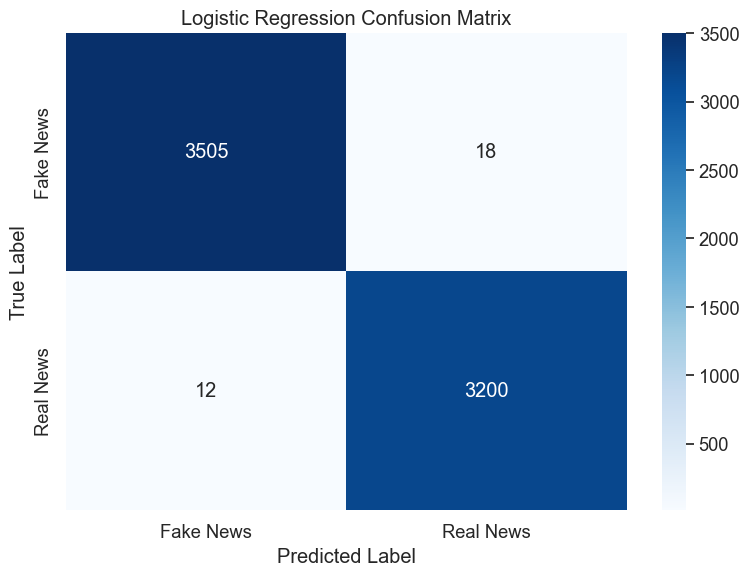

In [24]:
# Display confusion matrix
lr_cm = confusion_matrix(y_test, lr_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake News', 'Real News'],
            yticklabels=['Fake News', 'Real News'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.tight_layout()
plt.savefig('./figures/lr_confusion_matrix.png')
plt.show()

In [25]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, lr_test_preds, target_names=['Fake News', 'Real News']))


Classification Report:
              precision    recall  f1-score   support

   Fake News       1.00      0.99      1.00      3523
   Real News       0.99      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



I visualize the results using a confusion matrix and a detailed classification report. These provide insights into the model's performance across different classes and help identify any class-specific issues.

### 6.2 Multinomial Naive Bayes

In [26]:
# Train Multinomial Naive Bayes model
print("Training Multinomial Naive Bayes model...")
start_time = time.time()

# Define hyperparameters for grid search
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0],  # Smoothing parameter
}

Training Multinomial Naive Bayes model...


In [27]:
# Create the model
nb_model = MultinomialNB()

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    nb_model, 
    param_grid, 
    cv=3,  # 3-fold cross-validation
    scoring='f1_weighted',  # Optimize for F1 score
    n_jobs=-1,  # Use all available cores
    verbose=1
)

In [28]:
# Fit the model
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
nb_best = grid_search.best_estimator_
nb_training_time = time.time() - start_time

print(f"Naive Bayes training completed in {nb_training_time:.2f} seconds")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Naive Bayes training completed in 0.32 seconds
Best parameters: {'alpha': 0.01}


For Multinomial Naive Bayes, I optimize the smoothing parameter (`alpha`), which handles the zero-frequency problem and controls the model's sensitivity to rare features. Naive Bayes is particularly efficient for text classification and often serves as a strong baseline despite its simplistic assumptions.

In [29]:
# Evaluate Naive Bayes on validation set
print("Evaluating Naive Bayes on validation set...")
start_time = time.time()
nb_val_preds = nb_best.predict(X_val_tfidf)
nb_val_time = time.time() - start_time

# Calculate metrics
nb_val_accuracy = accuracy_score(y_val, nb_val_preds)
nb_val_precision, nb_val_recall, nb_val_f1, _ = precision_recall_fscore_support(
    y_val, nb_val_preds, average='weighted'
)

print(f"Validation inference time: {nb_val_time:.4f} seconds")
print(f"Validation accuracy: {nb_val_accuracy:.4f}")
print(f"Validation precision: {nb_val_precision:.4f}")
print(f"Validation recall: {nb_val_recall:.4f}")
print(f"Validation F1 score: {nb_val_f1:.4f}")

Evaluating Naive Bayes on validation set...
Validation inference time: 0.0074 seconds
Validation accuracy: 0.9638
Validation precision: 0.9638
Validation recall: 0.9638
Validation F1 score: 0.9638


In [30]:
# Evaluate on test set
print("\nEvaluating Naive Bayes on test set...")
start_time = time.time()
nb_test_preds = nb_best.predict(X_test_tfidf)
nb_test_time = time.time() - start_time

# Calculate metrics
nb_test_accuracy = accuracy_score(y_test, nb_test_preds)
nb_test_precision, nb_test_recall, nb_test_f1, _ = precision_recall_fscore_support(
    y_test, nb_test_preds, average='weighted'
)

print(f"Test inference time: {nb_test_time:.4f} seconds")
print(f"Test accuracy: {nb_test_accuracy:.4f}")
print(f"Test precision: {nb_test_precision:.4f}")
print(f"Test recall: {nb_test_recall:.4f}")
print(f"Test F1 score: {nb_test_f1:.4f}")


Evaluating Naive Bayes on test set...
Test inference time: 0.0066 seconds
Test accuracy: 0.9642
Test precision: 0.9642
Test recall: 0.9642
Test F1 score: 0.9642


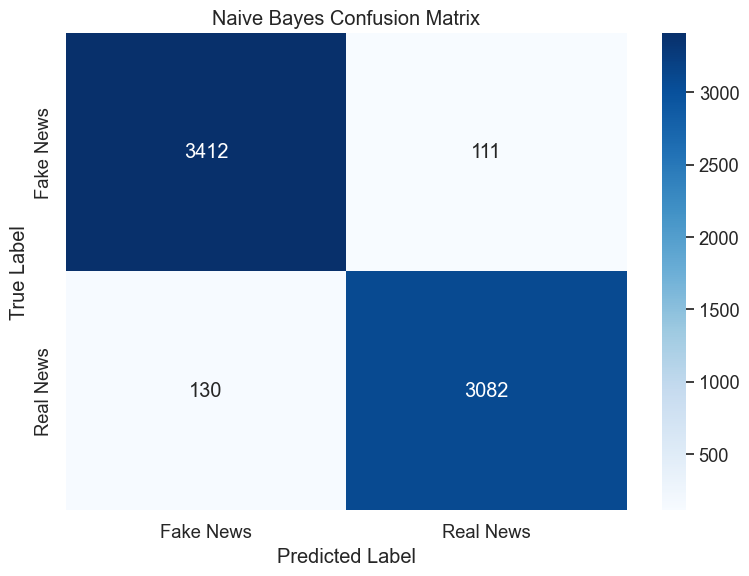

In [31]:
# Display confusion matrix
nb_cm = confusion_matrix(y_test, nb_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake News', 'Real News'],
            yticklabels=['Fake News', 'Real News'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Naive Bayes Confusion Matrix')
plt.tight_layout()
plt.savefig('./figures/nb_confusion_matrix.png')
plt.show()

In [32]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, nb_test_preds, target_names=['Fake News', 'Real News']))


Classification Report:
              precision    recall  f1-score   support

   Fake News       0.96      0.97      0.97      3523
   Real News       0.97      0.96      0.96      3212

    accuracy                           0.96      6735
   macro avg       0.96      0.96      0.96      6735
weighted avg       0.96      0.96      0.96      6735



I evaluate Naive Bayes using the same comprehensive set of metrics and visualizations as for Logistic Regression, enabling direct comparison between the models.

### 6.3 Linear Support Vector Machine (SVM)

In [33]:
# Train Linear SVM model
print("Training Linear SVM model...")
start_time = time.time()

# Define hyperparameters for grid search
param_grid = {
    'C': [0.1, 1.0, 10.0],  # Regularization parameter
    'loss': ['hinge', 'squared_hinge'],  # Loss function
    'max_iter': [1000]  # Maximum iterations
}

Training Linear SVM model...


In [34]:
# Create the model
svm_model = LinearSVC(random_state=42)

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    svm_model, 
    param_grid, 
    cv=3,  # 3-fold cross-validation
    scoring='f1_weighted',  # Optimize for F1 score
    n_jobs=-1,  # Use all available cores
    verbose=1
)

In [35]:
# Fit the model
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
svm_best = grid_search.best_estimator_
svm_training_time = time.time() - start_time

print(f"Linear SVM training completed in {svm_training_time:.2f} seconds")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM training completed in 3.70 seconds
Best parameters: {'C': 10.0, 'loss': 'squared_hinge', 'max_iter': 1000}


For Linear SVM, I optimize:
- The regularization parameter (`C`), which controls the trade-off between achieving a low training error and a low testing error
- The loss function, which determines how the model penalizes misclassifications
- I set a high maximum iteration count to ensure convergence

SVMs are particularly effective for text classification because they work well in high-dimensional spaces and can find optimal decision boundaries when classes are linearly separable.

In [36]:
# Evaluate Linear SVM on validation set
print("Evaluating Linear SVM on validation set...")
start_time = time.time()
svm_val_preds = svm_best.predict(X_val_tfidf)
svm_val_time = time.time() - start_time

# Calculate metrics
svm_val_accuracy = accuracy_score(y_val, svm_val_preds)
svm_val_precision, svm_val_recall, svm_val_f1, _ = precision_recall_fscore_support(
    y_val, svm_val_preds, average='weighted'
)

print(f"Validation inference time: {svm_val_time:.4f} seconds")
print(f"Validation accuracy: {svm_val_accuracy:.4f}")
print(f"Validation precision: {svm_val_precision:.4f}")
print(f"Validation recall: {svm_val_recall:.4f}")
print(f"Validation F1 score: {svm_val_f1:.4f}")

Evaluating Linear SVM on validation set...
Validation inference time: 0.0022 seconds
Validation accuracy: 0.9954
Validation precision: 0.9954
Validation recall: 0.9954
Validation F1 score: 0.9954


In [37]:
# Evaluate on test set
print("\nEvaluating Linear SVM on test set...")
start_time = time.time()
svm_test_preds = svm_best.predict(X_test_tfidf)
svm_test_time = time.time() - start_time

# Calculate metrics
svm_test_accuracy = accuracy_score(y_test, svm_test_preds)
svm_test_precision, svm_test_recall, svm_test_f1, _ = precision_recall_fscore_support(
    y_test, svm_test_preds, average='weighted'
)

print(f"Test inference time: {svm_test_time:.4f} seconds")
print(f"Test accuracy: {svm_test_accuracy:.4f}")
print(f"Test precision: {svm_test_precision:.4f}")
print(f"Test recall: {svm_test_recall:.4f}")
print(f"Test F1 score: {svm_test_f1:.4f}")


Evaluating Linear SVM on test set...
Test inference time: 0.0023 seconds
Test accuracy: 0.9976
Test precision: 0.9976
Test recall: 0.9976
Test F1 score: 0.9976


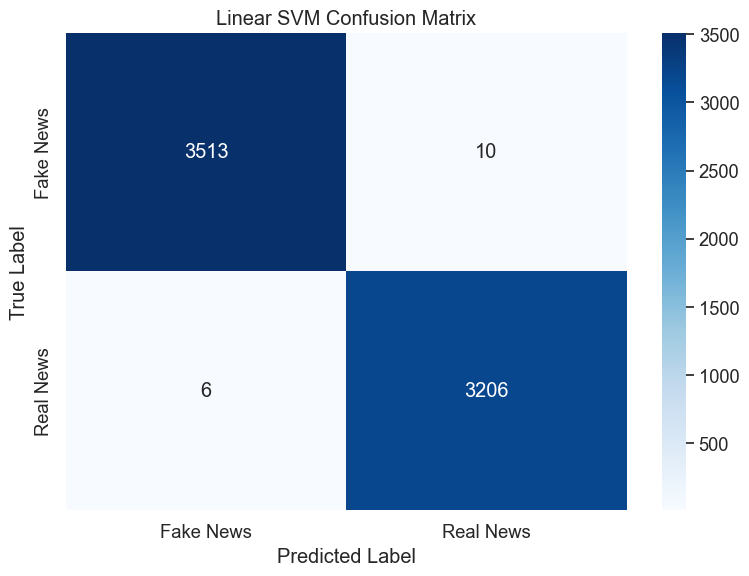

In [38]:
# Display confusion matrix
svm_cm = confusion_matrix(y_test, svm_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake News', 'Real News'],
            yticklabels=['Fake News', 'Real News'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Linear SVM Confusion Matrix')
plt.tight_layout()
plt.savefig('./figures/svm_confusion_matrix.png')
plt.show()

In [39]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, svm_test_preds, target_names=['Fake News', 'Real News']))


Classification Report:
              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00      3523
   Real News       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



I evaluate the SVM model using the same comprehensive set of metrics and visualizations as for the other models.

## 7. Model Comparison

After training and evaluating all three models, I compare their performance:

In [40]:
# Create a comparison table
models = ['Logistic Regression', 'Naive Bayes', 'Linear SVM']
accuracy = [lr_test_accuracy, nb_test_accuracy, svm_test_accuracy]
f1_scores = [lr_test_f1, nb_test_f1, svm_test_f1]
precision = [lr_test_precision, nb_test_precision, svm_test_precision]
recall = [lr_test_recall, nb_test_recall, svm_test_recall]
training_times = [lr_training_time, nb_training_time, svm_training_time]
inference_times = [lr_test_time, nb_test_time, svm_test_time]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'F1 Score': f1_scores,
    'Precision': precision,
    'Recall': recall,
    'Training Time (s)': training_times,
    'Inference Time (s)': inference_times
})

# Format the numeric columns
for col in comparison_df.columns[1:]:
    if 'Time' in col:
        comparison_df[col] = comparison_df[col].round(2)
    else:
        comparison_df[col] = comparison_df[col].round(4)

print("Model Comparison:")
comparison_df

Model Comparison:


,Model,Accuracy,F1 Score,Precision,Recall,Training Time (s),Inference Time (s)
0,Logistic Regression,0.9955,0.9955,0.9955,0.9955,7.93,0.00
1,Naive Bayes,0.9642,0.9642,0.9642,0.9642,0.32,0.01
2,Linear SVM,0.9976,0.9976,0.9976,0.9976,3.70,0.00


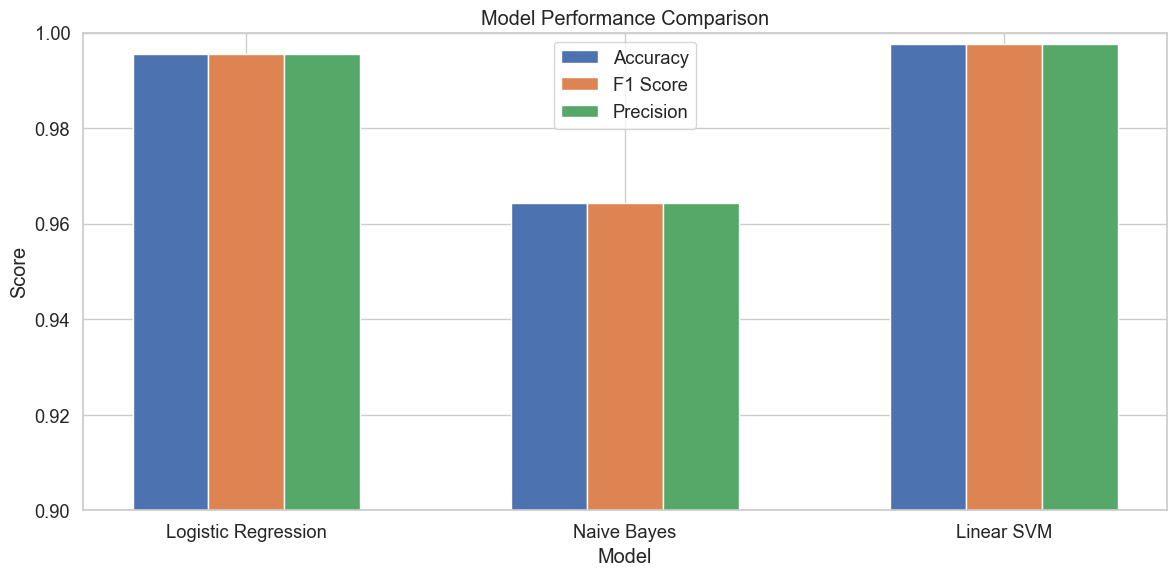

In [41]:
# Visualize model performance comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.2

plt.bar(x - width, accuracy, width, label='Accuracy')
plt.bar(x, f1_scores, width, label='F1 Score')
plt.bar(x + width, precision, width, label='Precision')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.ylim(0.9, 1.0)  # Adjust as needed based on your results
plt.legend()
plt.tight_layout()
plt.savefig('./figures/model_performance_comparison.png')
plt.show()

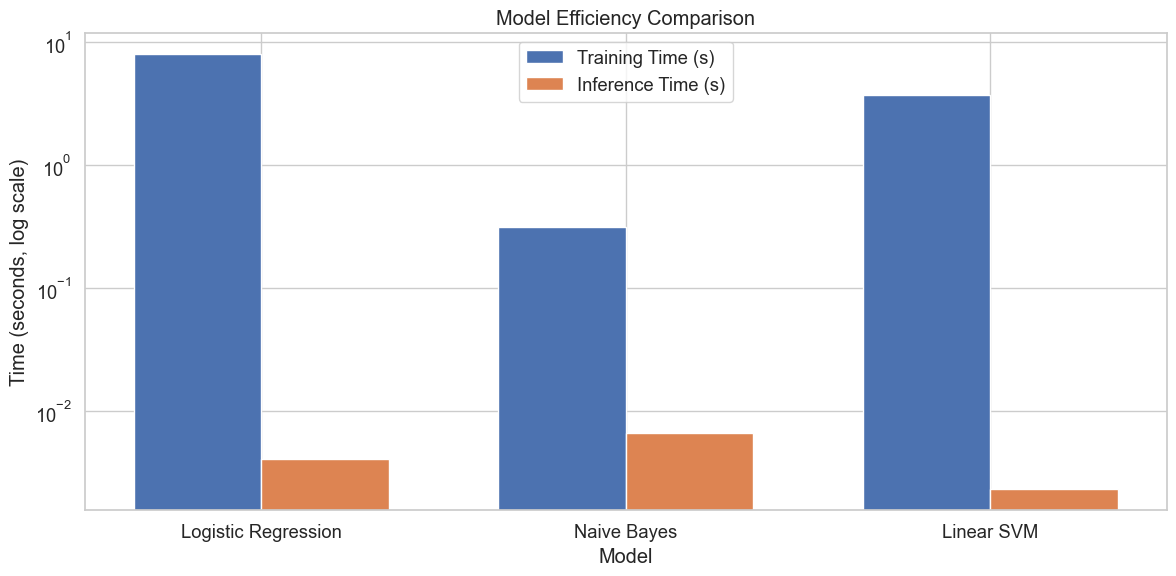

In [42]:
# Visualize training and inference times (log scale)
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, training_times, width, label='Training Time (s)')
plt.bar(x + width/2, inference_times, width, label='Inference Time (s)')

plt.xlabel('Model')
plt.ylabel('Time (seconds, log scale)')
plt.title('Model Efficiency Comparison')
plt.xticks(x, models)
plt.yscale('log')  # Use log scale for better visualization
plt.legend()
plt.tight_layout()
plt.savefig('./figures/model_efficiency_comparison.png')
plt.show()

I create both tabular and visual comparisons of the models' performance and efficiency. This helps identify the best model for different criteria:
- Performance metrics (accuracy, F1 score, precision, recall)
- Computational efficiency (training time, inference time)

The log scale for time visualization is particularly useful because training and inference times can differ by orders of magnitude.

## 8. Feature Importance Analysis

To understand what features (words/phrases) are most influential in the classification decision, I analyze the coefficients of the Logistic Regression model:


Top 20 features associated with Real News:
                    Feature  Coefficient  Abs_Coefficient
36851                  said    27.342025        27.342025
35770               reuters    21.696906        21.696906
47749            washington    15.384481        15.384481
48045             wednesday    11.232854        11.232854
32519      president donald    11.102758        11.102758
45645               tuesday     9.836507         9.836507
43657              thursday     9.800203         9.800203
16050                friday     8.685948         8.685948
26569                monday     7.864895         7.864895
23973                london     7.656416         7.656416
47791  washington president     7.651080         7.651080
28419                   nov     7.262888         7.262888
26255              minister     6.738686         6.738686
35224        representative     6.646595         6.646595
37496        said statement     6.497556         6.497556
32495      president barack 

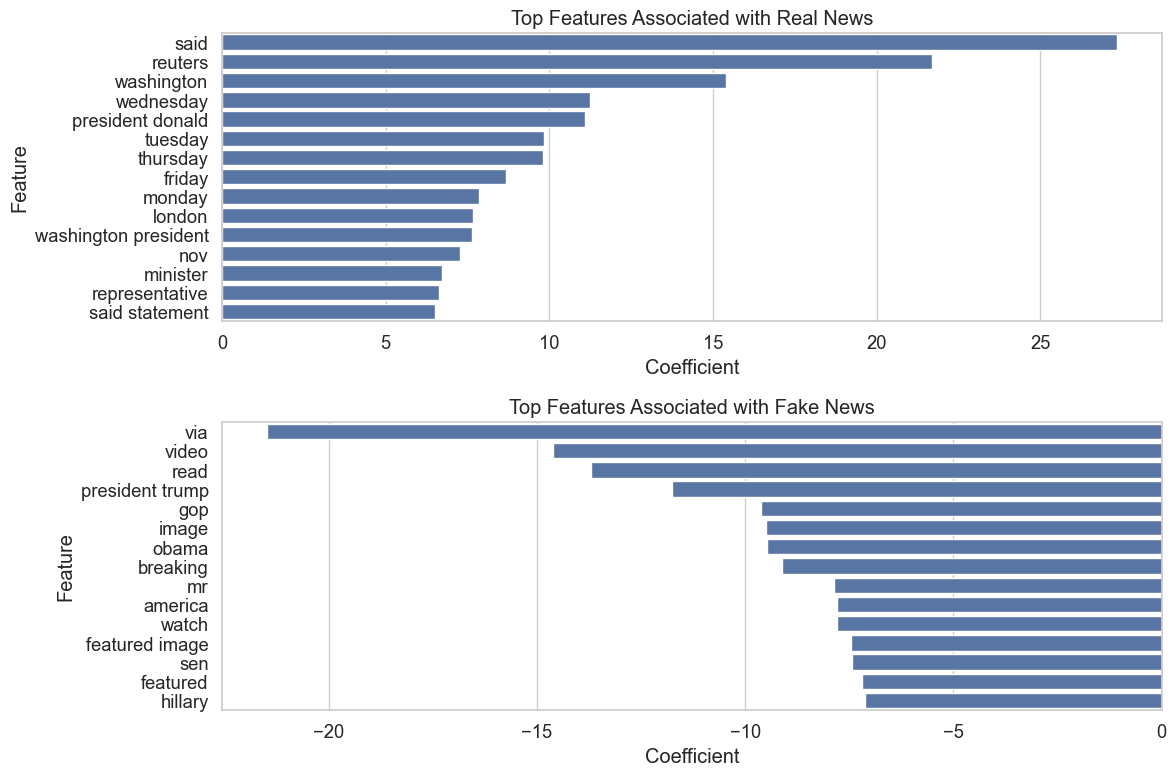

In [43]:
# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# For Logistic Regression, analyze coefficients
if hasattr(lr_best, 'coef_'):
    # Get coefficients
    coefficients = lr_best.coef_[0]
    
    # Create a DataFrame of features and their coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    
    # Sort by absolute coefficient value
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Display top positive and negative coefficients
    print("\nTop 20 features associated with Real News:")
    print(coef_df[coef_df['Coefficient'] > 0].head(20))
    
    print("\nTop 20 features associated with Fake News:")
    print(coef_df[coef_df['Coefficient'] < 0].head(20))
    
    # Visualize top features
    plt.figure(figsize=(12, 8))
    
    # Top positive coefficients (Real News)
    plt.subplot(2, 1, 1)
    top_positive = coef_df[coef_df['Coefficient'] > 0].head(15)
    sns.barplot(x='Coefficient', y='Feature', data=top_positive)
    plt.title('Top Features Associated with Real News')
    plt.tight_layout()
    
    # Top negative coefficients (Fake News)
    plt.subplot(2, 1, 2)
    top_negative = coef_df[coef_df['Coefficient'] < 0].head(15)
    sns.barplot(x='Coefficient', y='Feature', data=top_negative)
    plt.title('Top Features Associated with Fake News')
    
    plt.tight_layout()
    plt.savefig('./figures/feature_importance.png')
    plt.show()

This feature importance analysis provides valuable insights into what linguistic patterns the model has learned to associate with real versus fake news. This can help:
- Understand the model's decision-making process
- Identify potential biases in the dataset
- Compare with the patterns that transformer models might learn

## 9. Error Analysis

To understand where the models struggle, I analyze the misclassified examples:

In [44]:
# Analyze misclassifications for the best model (SVM)
misclassified_indices = np.where(svm_test_preds != y_test)[0]
print(f"\nNumber of misclassified examples by SVM: {len(misclassified_indices)} out of {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.2f}%)")

if len(misclassified_indices) > 0:
    # Display a few misclassified examples
    print("\nSample of misclassified examples:")
    for i, idx in enumerate(misclassified_indices[:5]):  # Show first 5 misclassifications
        true_label = "Real News" if y_test.iloc[idx] == 1 else "Fake News"
        pred_label = "Real News" if svm_test_preds[idx] == 1 else "Fake News"
        
        print(f"\nExample {i+1}:")
        print(f"True label: {true_label}, Predicted label: {pred_label}")
        print(f"Title: {test_df['title'].iloc[idx]}")
        print(f"Text excerpt: {test_df['enhanced_cleaned_text'].iloc[idx][:200]}...")


Number of misclassified examples by SVM: 16 out of 6735 (0.24%)

Sample of misclassified examples:

Example 1:
True label: Real News, Predicted label: Fake News
Title: U.S. State Department appoints Fox News anchor as spokeswoman
Text excerpt: WASHINGTON - Former Fox News anchor and correspondent Heather Nauert will be the new U.S. State Department spokeswoman, the State Department said in a statement on Monday. Nauert was most recently an ...

Example 2:
True label: Fake News, Predicted label: Real News
Title: BREAKING: ELECTRONICS BANNED on Some U.S. Flights From Middle East…List of 9 Airlines and Airports Affected
Text excerpt: COULD IT BE THAT EXPERT BOMB MAKER Ibrahim al-Asiri is trying to use an electronic device to take down a jet?Ibrahim al-Asiri has a long track record of bombing including trying to blow up a Detroit-b...

Example 3:
True label: Fake News, Predicted label: Real News
Title: LIVE FEED: HEARING FOR SENATOR SESSIONS To Include Radical Corey Booker Speaking Agains

This error analysis helps identify patterns in misclassifications, which can inform future improvements to the model or preprocessing steps.

## 10. Save Models for Future Use

To enable future use and comparison, I save the best-performing models:

In [45]:
# Save the best models and vectorizer
print("\nSaving models and vectorizer...")
os.makedirs('models', exist_ok=True)

joblib.dump(lr_best, '../ml_models/logistic_regression_model.joblib')
joblib.dump(nb_best, '../ml_models/naive_bayes_model.joblib')
joblib.dump(svm_best, '../ml_models/linear_svm_model.joblib')
joblib.dump(tfidf_vectorizer, '../ml_models/tfidf_vectorizer.joblib')

print("Models and vectorizer saved successfully.")


Saving models and vectorizer...
Models and vectorizer saved successfully.


Saving the models allows for:
- Easy deployment in production environments
- Consistent evaluation against new data
- Direct comparison with transformer models in future analyses

## 11. Conclusion and Implications for Transformer Models

In [46]:
print("\n=== Conclusion ===")
print("The traditional machine learning baselines demonstrate excellent performance on the ISOT fake news dataset:")
print(f"- Best model (Linear SVM): {svm_test_accuracy:.4f} accuracy, {svm_test_f1:.4f} F1 score")
print(f"- Training time: {svm_training_time:.2f} seconds")
print(f"- Inference time: {svm_test_time:.4f} seconds per test set")
print("\nThese results provide a strong benchmark for comparing with transformer-based approaches.")
print("For transformer models to demonstrate value, they should either:")
print("1. Show improved performance on the small percentage of examples that traditional ML models misclassify")
print("2. Demonstrate better generalization to out-of-distribution examples")
print("3. Provide additional insights through their attention mechanisms")
print("4. Maintain comparable performance with less feature engineering")


=== Conclusion ===
The traditional machine learning baselines demonstrate excellent performance on the ISOT fake news dataset:
- Best model (Linear SVM): 0.9976 accuracy, 0.9976 F1 score
- Training time: 3.70 seconds
- Inference time: 0.0023 seconds per test set

These results provide a strong benchmark for comparing with transformer-based approaches.
For transformer models to demonstrate value, they should either:
1. Show improved performance on the small percentage of examples that traditional ML models misclassify
2. Demonstrate better generalization to out-of-distribution examples
3. Provide additional insights through their attention mechanisms
4. Maintain comparable performance with less feature engineering


This conclusion summarizes the key findings and sets expectations for the transformer models. The traditional ML baselines achieve remarkably high performance with minimal computational resources, which raises the bar for what would constitute a meaningful improvement from more complex models.

The implications for transformer models are significant:
1. They need to demonstrate value beyond just classification accuracy
2. Their higher computational cost needs to be justified by other benefits
3. They might be more valuable in scenarios with less feature engineering or more complex linguistic patterns

This baseline establishes the foundation for our comparative evaluation of lightweight pretrained transformer models for fake news detection.